# Tutorial3: scDREAMER-Sup semi-supervised integration of Healthy Heart dataset

Here we present tutorial on semi-supervised integration of Healthy Heart dataset. The source of the dataset is [https://www.heartcellatlas.org/](https://www.heartcellatlas.org/) The heart cells are obtained in 147 batches corresponding to different donors, sequential protocols, race, gender, age range, and death conditions. Total 12 major cardiac cell types are assigned in this 486134 cells dataset and ~34000 cells are not assigned any cell label.

The Tutorial demonstrates scDREAMER-Sup's semi-supervised integration of large number of batches. 

<a href="https://colab.research.google.com/github/Zafar-Lab/scDREAMER/blob/main/2109_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importing Libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
import scanpy as sc
os.environ["CUDA_VISIBLE_DEVICES"] = "1" 
import random
import numpy as np
import tensorflow as tf2
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior() 

2023-09-26 15:05:37.471577: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-26 15:05:38.088576: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Instructions for updating:
non-resource variables are not supported in the long term


## Visualization of Healthy Heart data

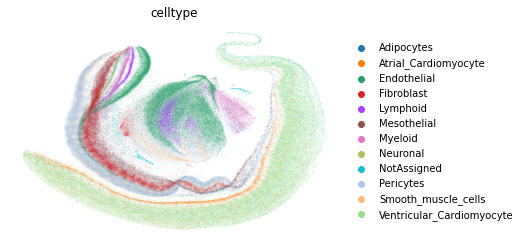

In [2]:
adata = sc.read_h5ad("/home/ajita/Documents/data_integration/Healthy_Heart/Healthy_human_heart_adata_subset.h5ad")
sc.pp.neighbors(adata, use_rep = "X") 
sc.tl.umap(adata)
sc.pl.umap(adata, color = "celltype", frameon = False)

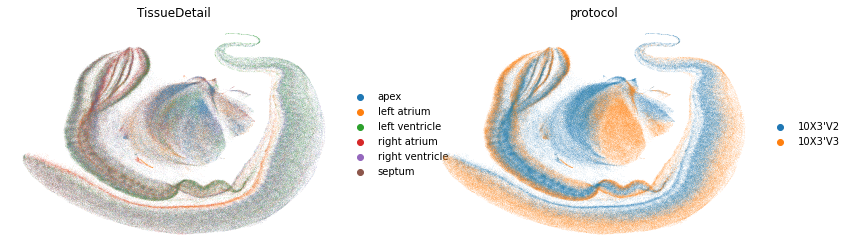

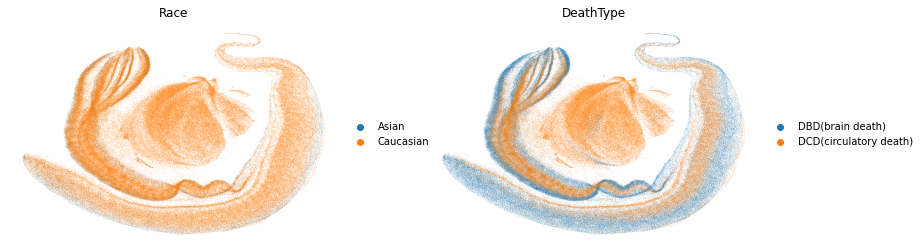

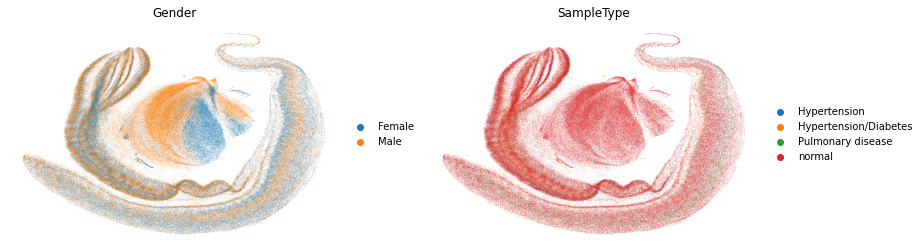

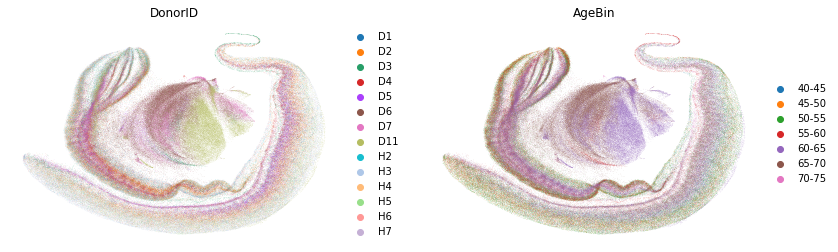

In [4]:
# Diversity of Samples
sc.pl.umap(adata, color = ["TissueDetail", "protocol"], frameon = False)
sc.pl.umap(adata, color = ["Race", "DeathType"], frameon = False)
sc.pl.umap(adata, color = ["Gender", "SampleType"], frameon = False)
sc.pl.umap(adata, color = ["DonorID", "AgeBin"], frameon = False)

## Setting seed for reproducibility

In [2]:

np.random.seed(0)
tf.set_random_seed(0)
random.seed(0)
tf2.random.set_seed(0)
tf2.keras.utils.set_random_seed(0)


## Building model

In [3]:

name = "Healthy_Heart"

"""
NOTE:
Run setting as follows:
0: Supervised setting: In case of healthy heart, semi-supervised setting for "Not-assigned" cells
10: 10 percent missing labels data
20: 20 percent missing labels data
50: 50 percent missing labels data
"""
run_setting = 0

## Run setting

In [4]:


path = "/home/ajita/Documents/data_integration/"

data_path = {

"Healthy_Heart" : {0: path + "Healthy_Heart/Healthy_human_heart_adata_subset.h5ad"
                 }
}


batch_key_dict = {'Immune_Human' : 'batch',
                 "Healthy_Heart" : "sampleID"
                 
                }

"""
In semi-supervised setting,  cells with cell type labels "NA" will not 
participate in training the cell-type classifier"

"""

cell_type_key_dict = {
    "Healthy_Heart" : {0: "celltype_NA" }  
}

lr_big_data = {"lr_ae" : 0.0001, "lr_dis": 0.00001}

learning_rate = {
"Healthy_Heart" : {0: lr_big_data, 20: lr_big_data, 50: lr_big_data}}


plot_cell_type_dict = {
                    "Healthy_Heart" : "celltype",

                    } 

## scDREAMER model

2023-09-21 20:04:59.946007: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5367 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:d8:00.0, compute capability: 7.5


Loading dataset
Preprocessing...
here [10 11 11 ...  2  2  2]
Shape self.data_train: (485511, 2000)
Shape self.data_test: (485511, 2000)
encoder input shape  Tensor("concat:0", shape=(?, 2147), dtype=float32)
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use `tf.cast` instead.
decoder input shape  Tensor("concat_2:0", shape=(?, 157), dtype=float32)
KL gaussian z Tensor("mul_12:0", shape=(?,), dtype=float32)
KL gaussian l Tensor("mul_11:0", shape=(?,), dtype=float32)
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

scDREAMER-Sup on DataSet /home/ajita/Documents/data_integration/Healthy_Heart/Healthy_human_heart_adata_subset.h5ad ... 


2023-09-21 20:06:58.537832: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:353] MLIR V1 optimization pass is not enabled


Epoch : [0] ,  a_loss = 217.2630
Epoch : [10] ,  a_loss = 194.5482
Epoch : [20] ,  a_loss = 189.7468
Epoch : [30] ,  a_loss = 187.8285
Epoch : [40] ,  a_loss = 186.5633
Epoch : [50] ,  a_loss = 186.2601
Epoch : [60] ,  a_loss = 185.5387
Epoch : [70] ,  a_loss = 184.7160
Epoch : [80] ,  a_loss = 184.6446
Epoch : [90] ,  a_loss = 184.2780
Epoch : [100] ,  a_loss = 183.8163
Epoch : [110] ,  a_loss = 183.4391
Epoch : [120] ,  a_loss = 182.9392
Epoch : [130] ,  a_loss = 182.6407
Epoch : [140] ,  a_loss = 181.9946
Epoch : [150] ,  a_loss = 181.7168
Epoch : [160] ,  a_loss = 181.2697
Epoch : [170] ,  a_loss = 180.9640
Epoch : [180] ,  a_loss = 180.4101
Epoch : [190] ,  a_loss = 180.0579
Epoch : [200] ,  a_loss = 179.8580
Epoch : [210] ,  a_loss = 179.6591
Epoch : [220] ,  a_loss = 179.5249
Epoch : [230] ,  a_loss = 179.5214
Epoch : [240] ,  a_loss = 179.6433
Epoch : [250] ,  a_loss = 179.9576
Epoch : [260] ,  a_loss = 179.8742
Epoch : [270] ,  a_loss = 180.0580
Epoch : [280] ,  a_loss = 180.1

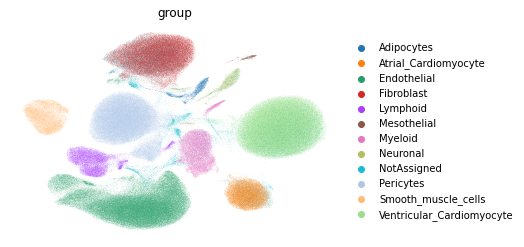

None


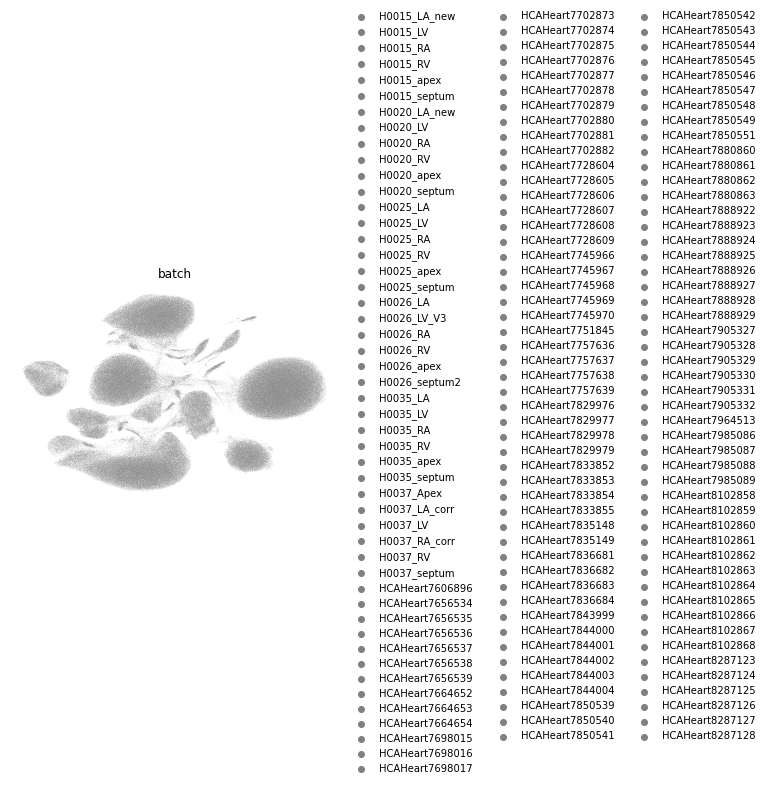

Done !


In [5]:

import scDREAMER_SUP.model as model


run_config = tf.ConfigProto()

run_config.gpu_options.per_process_gpu_memory_fraction = 0.333
run_config.gpu_options.allow_growth = True

with tf.Session(config = run_config) as sess:

    dreamer = model.scDREAMER_SUP(
        sess,
        epoch = 300,
        dataset_name = data_path[name][run_setting],
        batch = batch_key_dict[name],
        cell_type = cell_type_key_dict[name][run_setting],
        plot_cell_type = plot_cell_type_dict[name],
        name = name,
        lr_ae = learning_rate[name][run_setting]['lr_ae'],
        lr_dis = learning_rate[name][run_setting]['lr_dis']
        )

    dreamer.train_cluster()

    